<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #3
## Реализация алгоритма дерева решений

<img src='../img/quote_feynman.jpg' width=50%>

### Задача состоит в том, чтобы:
 1. написать код и выполнить вычисления в ячейках ниже;
 2. выбрать ответы в [веб-форме](https://docs.google.com/forms/d/1SYwUD0Yx_bcykq6EqFQ4Ug0KaQWG4L7bAlL5yGedZnw).
    

*Если вы уверены, что в задании/решении что-то не на 100% верно, пожалуйста, оставьте свой отзыв через указанную веб-форму ↑*.

-----

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.datasets import (
#     load_boston,
    load_digits,
    make_classification,
    make_regression,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'

**Реализация класса `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор класса имеет следующие параметры: 
    - `max_depth` - максимальная глубина дерева (по умолчанию `numpy.inf`); 
    - `min_samples_split` - минимальное количество экземпляров в узле для проведения разбиения (по умолчанию 2); 
    - `criterion` - критерий разбиения ("gini" или "entropy" для классификации, "variance" или "mad_median" для регрессии; по умолчанию "gini");
- класс имеет несколько методов: `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу экземпляров `X` и целевой вектор `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса `DecisionTree`, представляющий собой дерево решений, обученное на наборе данных `(X, y)` в соответствии с параметрами, заданными в конструкторе;
- метод `predict_proba` принимает матрицу экземпляров `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - количество классов, а $p_{ij}$ - вероятность принадлежности экземпляра в $i$-й строке `X` к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу экземпляров `X` и возвращает вектор предсказаний; в случае классификации предсказанием для экземпляра $x_i$, попадающего в лист $L$, будет класс, наиболее представленный среди экземпляров в $L$. В случае регрессии это будет среднее значение целей для всех экземпляров в листе $L$.

Примечание по `criterion`: это функционал, который необходимо максимизировать для нахождения оптимального разбиения в данном узле, имеет вид $Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$ где $X$ - сэмплы в данном узле, $X_l$ и $X_r$ - разбиения сэмплов $X$ на две части с условием $[x_j < t]$, а $F(X)$ - критерий разбиения.

Для классификации: пусть $p_i$ - доля экземпляров $i$-го класса в наборе данных $X$.
- 'gini': Примесь (критерий) Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
- 'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
Для регрессии: $y_j = y(x_j)$ - цель для экземпляра $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор целей.
- 'variance': Дисперсия (среднеквадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$.
- 'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$.
    

In [2]:
def entropy(y):
    p = [ len(y[y == i]) / len(y) for i in np.unique(y) ]
    return -np.dot(p, np.log2(p))


def gini(y):
    p = [ len(y[y == i]) / len(y) for i in np.unique(y) ]
    return 1 - np.dot(p, p)


def variance(y):
    return np.var(y)


def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))


criteria = {
    "entropy": entropy,
    "gini": gini,
    "variance": variance,
    "mad_median": mad_median
}

Класс `Node` реализует узел в дереве решений.

In [3]:
class Node:
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Определим функцию для вычисления предсказания в листе. Для регрессии возьмем среднее значение для всех значений в листе, для классификации - наиболее популярный класс в листе.

In [4]:
def regression_leaf(y):
    return np.mean(y)


def classification_leaf(y):
    return np.bincount(y).argmax()

In [5]:
class DecisionTree(BaseEstimator):
    def __init__(
        self, max_depth=np.inf, min_samples_split=2, criterion="gini", debug=False
    ):
        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "criterion": criterion,
            "debug": debug
        }
        for name, value in params.items():
            setattr(self, name, value)

        super(DecisionTree, self).set_params(**params)
        
        self._criterion_function = criteria[criterion]
        
        if criterion in ["variance", "mad_median"]:
            self._leaf = regression_leaf
        else:
            self._leaf = classification_leaf
        
        if debug:
            print(f"DecisionTree:\n{params}")


    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left
        
        left = y[np.where(mask)]
        right = y[np.where(~mask)]
        if n_left > 0 and n_right > 0:
            return (
                self._criterion_function(y)
                - (n_left / n_obj) * self._criterion_function(left)
                - (n_right / n_obj) * self._criterion_function(right)
            )
        return 0.

    def _build_tree(self, X, y, depth=1):
        max_functional = 0.
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape
        
        
        if len(np.unique(y)) == 1:
            return Node(labels=y)
        
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print(f"{depth = }, {n_samples = }")

            for feature_idx in range(n_features):
                threshold_values = np.unique(X[:, feature_idx])
                functional_values = [
                    self._functional(X, y, feature_idx, threshold)
                    for threshold in threshold_values
                ]
                
                best_threshold_idx = np.nanargmax(functional_values)
                
                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold
        
        if best_feature_idx is not None:
            if self.debug:
                print(f"{best_feature_idx = } {best_threshold = }")
            
            return Node(
                feature_idx=best_feature_idx,
                threshold=best_threshold,
                left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1)
            )
        
        return Node(labels=y)


    def fit(self, X, y):
        if self.criterion in ["gini", "entropy"]:
            self._n_classes = len(np.unique(y))
        
        self.root = self._build_tree(X, y)
        
        return self

    def _predict_object(self, x, node=None):
        node = self.root
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        return self._leaf(node.labels)
    
    def predict(self, X):
        return np.array([self._predict_object(x) for x in X])

    
    def _predict_proba_object(self, x, node=None):
        node = self.root
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        return [
            len(node.labels[node.labels == k]) / len(node.labels)
            for k in range(self._n_classes)
        ]
    
    
    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])

## Тестирование реализованного алгоритма

### Классификация

accuracy = 0.85
predict_proba works!


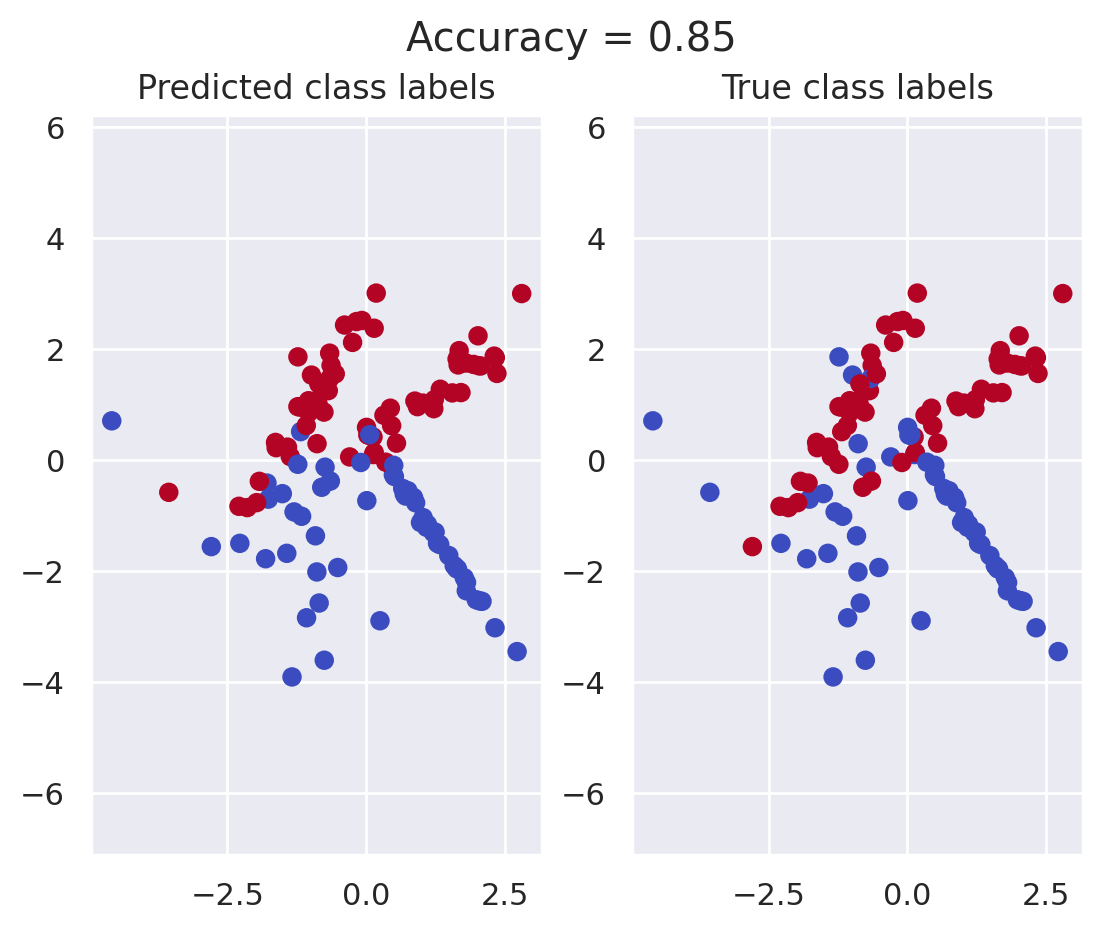

In [6]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_samples=400, random_state=17
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=17
)

clf = DecisionTree(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"{accuracy = }")

if sum(np.argmax(prob_pred, axis=1) - y_pred) == 0:
    print("predict_proba works!")

plt.suptitle(f"Accuracy = {accuracy:.2f}")
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal");

Загрузите набор данных `digits` с помощью метода `load_digits`. Разделите данные на обучающие и тестовые с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2` и `random_state=17`. Попробуйте обучить неглубокие деревья решений и убедитесь, что критерии gini и entropy дают разные результаты.

In [7]:
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=17)

clf_gini = DecisionTree(max_depth=2, criterion="gini", debug=True)
clf_gini.fit(X_train, y_train)
print(accuracy_score(clf_gini.predict(X_test), y_test))

print('_' * 50 + "\n")

clf_entropy = DecisionTree(max_depth=2, criterion="entropy", debug=True)
clf_entropy.fit(X_train, y_train)
print(accuracy_score(clf_entropy.predict(X_test), y_test))

DecisionTree:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'debug': True}
depth = 1, n_samples = 1437
best_feature_idx = 36 best_threshold = 1.0
0.18888888888888888
__________________________________________________

DecisionTree:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'debug': True}
depth = 1, n_samples = 1437
best_feature_idx = 21 best_threshold = 2.0
0.175


С помощью 5-кратной перекрестной валидации (`GridSearchCV`) подобрать оптимальные значения параметров `max_depth` и `criterion`. Для параметра `max_depth` используем range(3, 11), для критерия - {'gini', 'entropy'}. Мерой качества является `scoring`="accuracy".

In [8]:
tree_params = { "max_depth": list(range(3, 11)) }

In [9]:
%%time
grid_gini = GridSearchCV(
    estimator=DecisionTree(criterion="gini"),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_gini.fit(X_train, y_train)

print(grid_gini.best_score_, grid_gini.best_params_)

0.8434306039488966 {'max_depth': 10}
CPU times: user 2.8 s, sys: 98.4 ms, total: 2.89 s
Wall time: 12.9 s


In [10]:
%%time
grid_entropy = GridSearchCV(
    estimator=DecisionTree(criterion="entropy"),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_entropy.fit(X_train, y_train)

print(grid_entropy.best_score_, grid_entropy.best_params_)

0.8629186024003097 {'max_depth': 9}
CPU times: user 2.75 s, sys: 4.64 ms, total: 2.75 s
Wall time: 14.5 s


Построим график средней меры качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

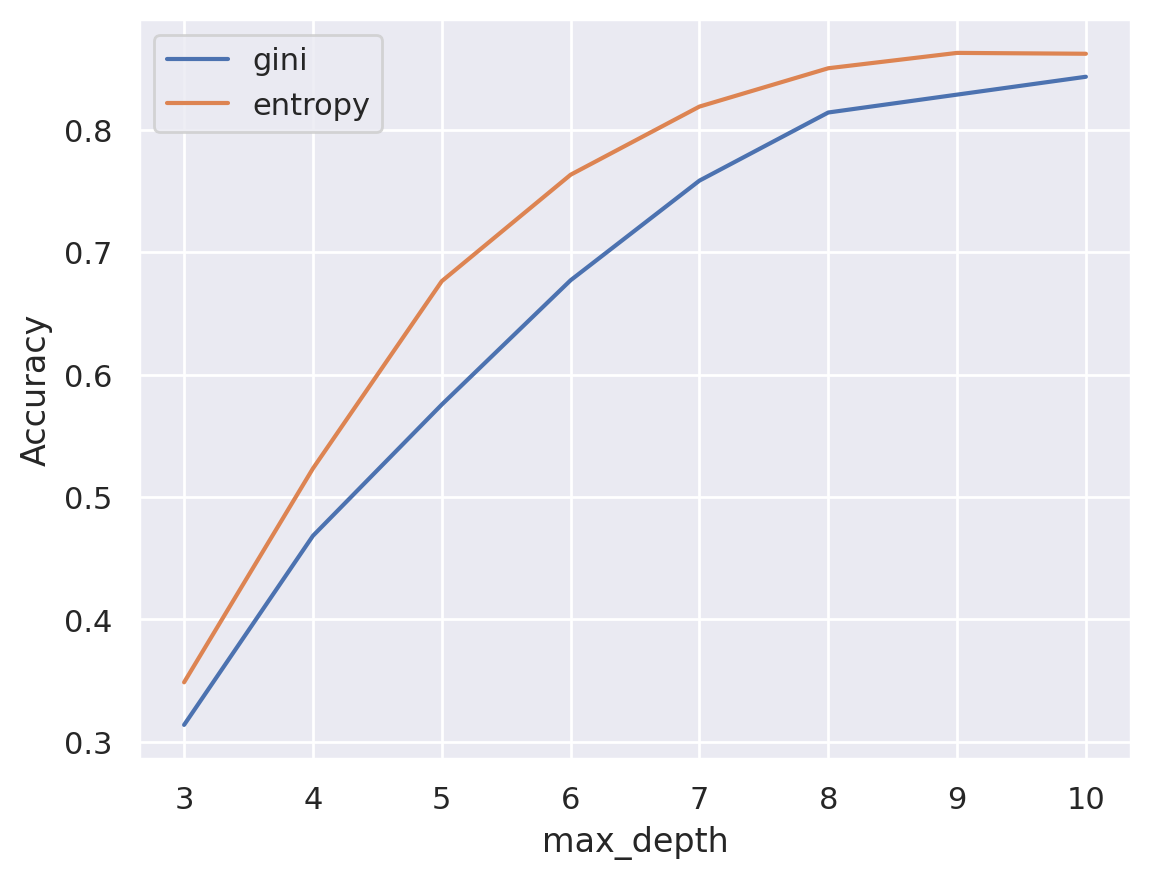

In [11]:
scores_gini = np.array(grid_gini.cv_results_["mean_test_score"])
scores_entropy = np.array(grid_entropy.cv_results_["mean_test_score"])

plt.plot(tree_params["max_depth"], scores_gini, label="gini")
plt.plot(tree_params["max_depth"], scores_entropy, label="entropy")
plt.legend(loc="best")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.show();

**1. Выберите все правильные утверждения:**
1. Оптимальное значение параметра `max_depth` находится на интервале [4, 9] для обоих критериев.
2. Созданные графики не имеют пересечений на отрезке [3, 10].
3. Созданные графики пересекаются друг с другом только один раз на отрезке [3, 10].
4. Наилучшее качество для `max_depth` на интервале [3, 10] достигается с помощью критерия `gini` .
5. Точность строго возрастает хотя бы для одного из критериев, когда `max_depth` также возрастает на интервале [3, 10].

Ответы: 2, 5

**2. Каковы оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Ответ: 5

Обучить дерево решений на `(X_train, y_train)`, используя оптимальные значения `max_depth` и `criterion`. Вычислить вероятности классов для `X_test`.

In [12]:
clf = DecisionTree(max_depth=9, criterion="entropy")
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)

Используя заданную матрицу, вычислить средние вероятности классов для всех экземпляров в `X_test`.

In [13]:
mean_probs = np.mean(probs, axis=0)
print(mean_probs, max(mean_probs))

[0.09166667 0.07700282 0.09854938 0.08930086 0.12690476 0.11898148
 0.08194444 0.09805556 0.10465062 0.11294341] 0.12690476190476194


**3. Чему равна максимальная вероятность в приведенном векторе?**
1. 0.127
2. 0.118
3. 1.0
4. 0.09

Ответ: 1

### Регрессия

mse = 165.7607358208333


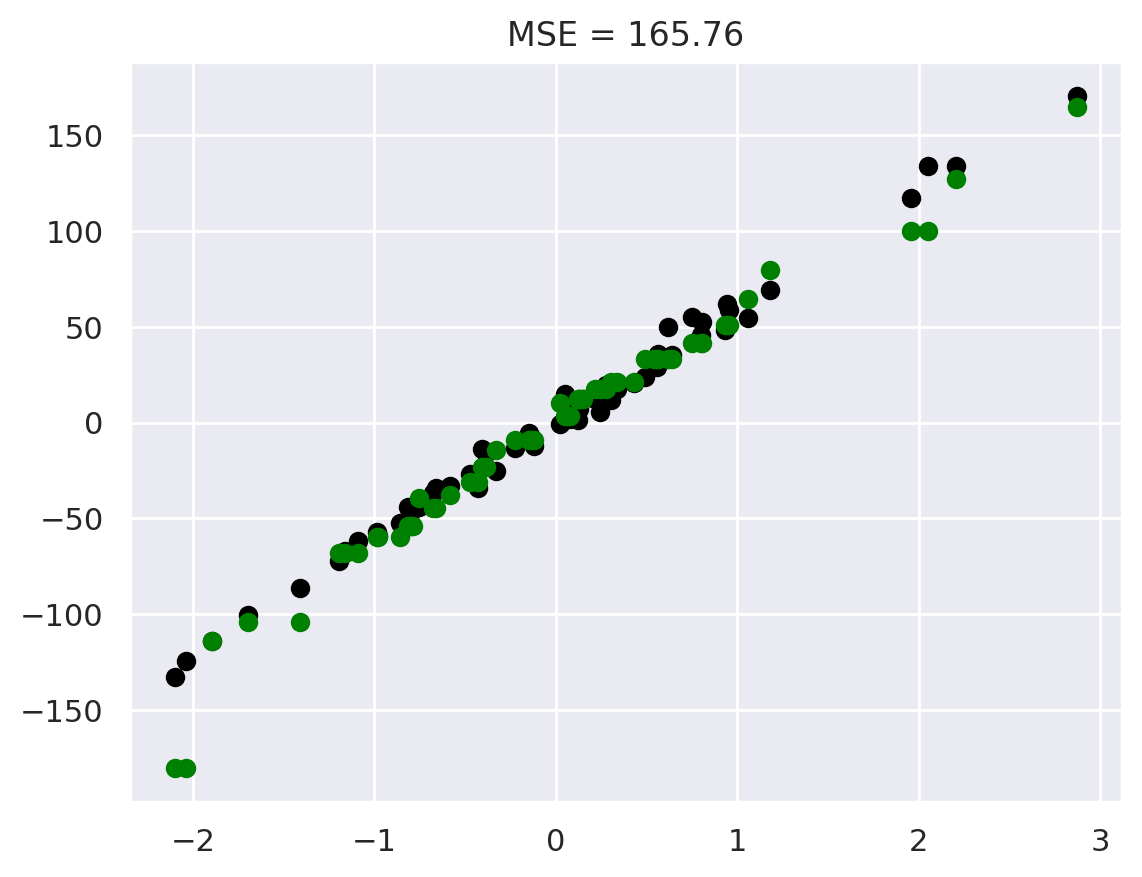

In [14]:
X, y = make_regression(
    n_features=1, n_samples=200, bias=0, noise=5, random_state=17
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=17
)

reg = DecisionTree(max_depth=6, criterion="mad_median")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"{mse = }")

plt.scatter(X_test[:, 0], y_test, color="black")
plt.scatter(X_test[:, 0], y_pred, color="green")
plt.title(f"MSE = {mse:.2f}");

Загрузите набор данных `boston` с помощью метода `load_boston`. Разделите данные на обучающие и тестовые с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить деревья решений с неглубокой регрессией и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [15]:
raw_df = pd.read_csv("http://lib.stat.cmu.edu/datasets/boston", sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=.2, random_state=17
)

С помощью 5-кратной перекрестной валидации (`GridSearchCV`) подобрать оптимальные значения параметров `max_depth` и `criterion`. Для параметра `max_depth` используется `range(2, 9)`, для `criterion` - {'variance', 'mad_median'}. Мера качества - `scoring`='neg_mean_squared_error'.

In [16]:
%%time
tree_params = {"max_depth": list(range(2, 9))}
grid_variance = GridSearchCV(
    estimator=DecisionTree(criterion="variance"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_variance.fit(X_train, y_train)

CPU times: user 736 ms, sys: 2.7 ms, total: 739 ms
Wall time: 3.31 s


GridSearchCV(cv=5, estimator=DecisionTree(criterion='variance'), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [17]:
%%time
tree_params = {"max_depth": list(range(2, 9))}
grid_mad_median = GridSearchCV(
    estimator=DecisionTree(criterion="mad_median"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_mad_median.fit(X_train, y_train)

CPU times: user 997 ms, sys: 11.4 ms, total: 1.01 s
Wall time: 6.05 s


GridSearchCV(cv=5, estimator=DecisionTree(criterion='mad_median'), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

Построим график средней меры качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

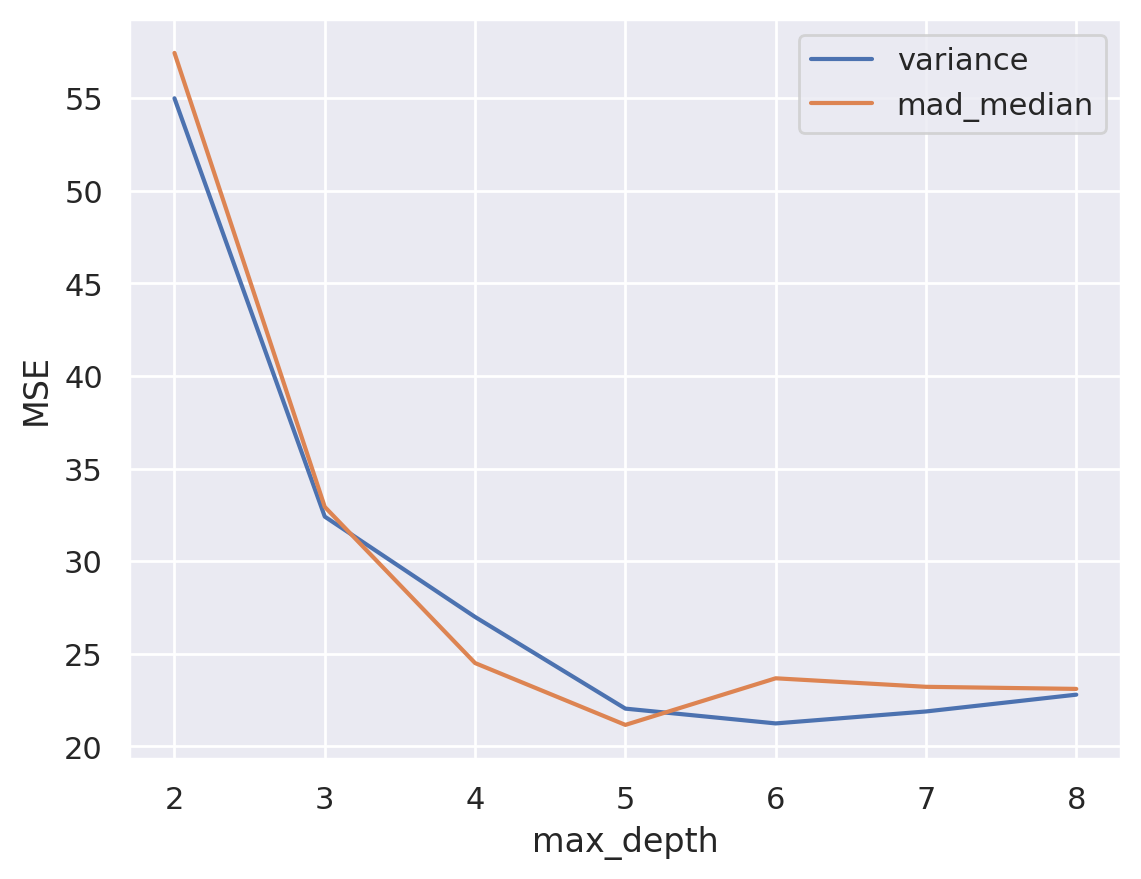

In [18]:
scores_variance = -np.array(
    grid_variance.cv_results_["mean_test_score"]
)
scores_mad_median = -np.array(
    grid_mad_median.cv_results_["mean_test_score"]
)

plt.plot(tree_params["max_depth"], scores_variance, label="variance")
plt.plot(tree_params["max_depth"], scores_mad_median, label="mad_median")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show();

**4. Выберите все правильные утверждения:**
1. Созданные графики не имеют пересечений на отрезке [2, 8].
2. Построенные графики пересекаются между собой только один раз на отрезке [2, 8].
3. Оптимальное значение `max_depth` для каждого из критериев находится на границе интервала [2, 8].
4. Наилучшее качество при `max_depth` на интервале [2, 8] достигается при использовании критерия `mad_median`.

Ответ: 4

**5. Каковы оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.

Ответ: 2